# 台灣銀行牌告匯率爬蟲練習
## 範例1： 練習爬取台幣對其他貨幣匯率資料

In [6]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

### 進入台灣銀行牌告匯率網頁：https://rate.bot.com.tw/xrt?Lang=zh-TW ，擷取當日台幣對美金的匯率資訊

In [7]:
# 進入台灣銀行牌告匯率網頁，查看當日匯率資料
url = "https://rate.bot.com.tw/xrt?Lang=zh-TW"
resp = requests.get(url)
resp.encoding = 'utf-8'
# print(resp.text)  # 如有需要，列印出網頁原始碼

html = BeautifulSoup(resp.text, "lxml")
rate_table = html.find(name='table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')

# 查詢美金(也就是匯率表的第一個元素)對台幣的匯率
currency = rate_table[0].find(name='div', attrs={'class':'visible-phone print_hide'})
print(currency.get_text().replace(" ", ""))  # 去掉空白

buy_rate = rate_table[0].find(name='td', attrs={'data-table':'本行現金買入'})
sell_rate = rate_table[0].find(name='td', attrs={'data-table':'本行現金賣出'})
print("即時現金買入: %s, 即時現金賣出: %s" % (buy_rate.get_text(), sell_rate.get_text()))


美金(USD)

即時現金買入: 29.485, 即時現金賣出: 30.155


### 作業part 1：請參考上面的範例，試著爬取所有貨幣對台幣的匯率

In [8]:
all_currency = html.find('tbody').find_all('tr')
for i in all_currency:#加上.find('tbody')更精準地鎖定tr的位置

    print(i.find('div').find('div',class_='hidden-phone print_show').text.replace(' ','').replace('\t','').replace('\n','').replace('\r',''))

    buy_=i.find('td',attrs={'data-table':'本行現金買入'}).text
    sell_=i.find('td',attrs={'data-table':'本行現金賣出'}).text
    print('本行現金買入:{}\n本行現金買出:{}'.format(buy_,sell_))
    print('==================================================')
   

美金(USD)
本行現金買入:29.485
本行現金買出:30.155
港幣(HKD)
本行現金買入:3.699
本行現金買出:3.903
英鎊(GBP)
本行現金買入:36.29
本行現金買出:38.41
澳幣(AUD)
本行現金買入:20.27
本行現金買出:21.05
加拿大幣(CAD)
本行現金買入:21.64
本行現金買出:22.55
新加坡幣(SGD)
本行現金買入:20.76
本行現金買出:21.67
瑞士法郎(CHF)
本行現金買入:30.27
本行現金買出:31.47
日圓(JPY)
本行現金買入:0.2647
本行現金買出:0.2775
南非幣(ZAR)
本行現金買入:-
本行現金買出:-
瑞典幣(SEK)
本行現金買入:2.83
本行現金買出:3.35
紐元(NZD)
本行現金買入:18.73
本行現金買出:19.58
泰幣(THB)
本行現金買入:0.8192
本行現金買出:1.0092
菲國比索(PHP)
本行現金買入:0.5249
本行現金買出:0.6579
印尼幣(IDR)
本行現金買入:0.00178
本行現金買出:0.00248
歐元(EUR)
本行現金買入:32.71
本行現金買出:34.05
韓元(KRW)
本行現金買入:0.02282
本行現金買出:0.02672
越南盾(VND)
本行現金買入:0.00091
本行現金買出:0.00141
馬來幣(MYR)
本行現金買入:5.877
本行現金買出:7.502
人民幣(CNY)
本行現金買入:4.096
本行現金買出:4.258


## 範例2：爬取一個月的美金對台幣歷史匯率資料，並畫出趨勢圖


美金(USD)



<Figure size 720x576 with 0 Axes>

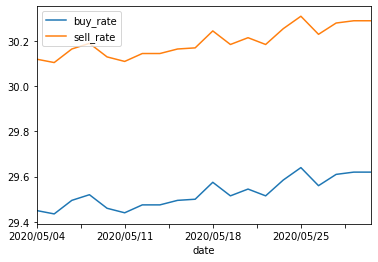

In [9]:
# 先到牌告匯率首頁，爬取所有貨幣的種類
url = "https://rate.bot.com.tw/xrt?Lang=zh-TW"
resp = requests.get(url)
resp.encoding = 'utf-8'
html = BeautifulSoup(resp.text, "lxml")
rate_table = html.find(name='table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')

# 擷取匯率表格，把美金(也就是匯率表的第一個元素)擷取出來，查詢其歷史匯率
currency = rate_table[0].find(name='div', attrs={'class':'visible-phone print_hide'})
print(currency.get_text().replace(" ", ""))  # 貨幣種類

# 針對美金，找到其「歷史匯率」的首頁 
history_link = rate_table[0].find(name='td', attrs={'data-table':'歷史匯率'})
history_rate_link = "https://rate.bot.com.tw" + history_link.a["href"]  # 該貨幣的歷史資料首頁

#
# 到貨幣歷史匯率網頁，選則該貨幣的「歷史區間」，送出查詢後，觀察其網址變化情形，再試著抓取其歷史匯率資料
#
# 用「quote/年-月」去取代網址內容，就可以連到該貨幣的歷史資料
quote_history_url = history_rate_link.replace("history", "quote/2020-05")
resp = requests.get(quote_history_url)
resp.encoding = 'utf-8'
history = BeautifulSoup(resp.text, "lxml")
history_table = history.find(name='table', attrs={'title':'歷史本行營業時間牌告匯率'}).find(name='tbody').find_all(name='tr')

#
# 擷取到歷史匯率資料後，把資料彙整起來並畫出趨勢圖
#
date_history = list()
history_buy = list()
history_sell = list()

for history_rate in history_table:
    # 擷取日期資料
    date_string = history_rate.a.get_text()
    date = datetime.strptime(date_string, '%Y/%M/%d').strftime('%Y/%M/%d')  # 轉換日期格式
    date_history.append(date)  # 日期歷史資料

    history_ex_rate = history_rate.find_all(name='td', attrs={'class':'rate-content-cash text-right print_table-cell'})
    history_buy.append(float(history_ex_rate[0].get_text()))  # 歷史買入匯率
    history_sell.append(float(history_ex_rate[1].get_text()))  # 歷史賣出匯率

# 將匯率資料建成dataframe形式
HistoryExchangeRate = pd.DataFrame({'date': date_history,
                                    'buy_rate':history_buy,
                                    'sell_rate':history_sell})

HistoryExchangeRate = HistoryExchangeRate.set_index('date')  # 指定日期欄位為datafram的index
HistoryExchangeRate = HistoryExchangeRate.sort_index(ascending=True)

# 畫出歷史匯率軌跡圖
plt.figure(figsize=(10, 8))
HistoryExchangeRate[['buy_rate','sell_rate']].plot()  # x=['date'], y=[['buy_rate','sell_rate']] 
plt.legend(loc="upper left")
plt.show()

### 作業part 2：爬取每種貨幣對台幣的一個月歷史匯率資料，並畫出趨勢圖

美金(USD)


<Figure size 720x576 with 0 Axes>

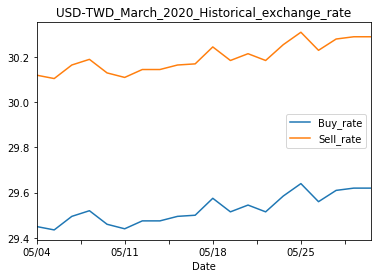

港幣(HKD)


<Figure size 720x576 with 0 Axes>

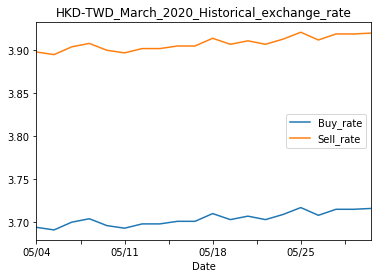

英鎊(GBP)


<Figure size 720x576 with 0 Axes>

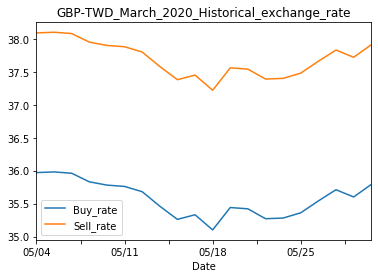

澳幣(AUD)


<Figure size 720x576 with 0 Axes>

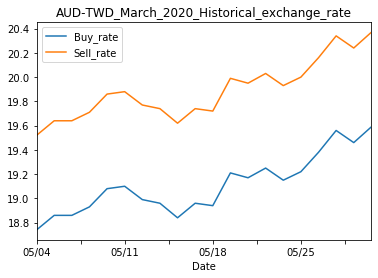

加拿大幣(CAD)


<Figure size 720x576 with 0 Axes>

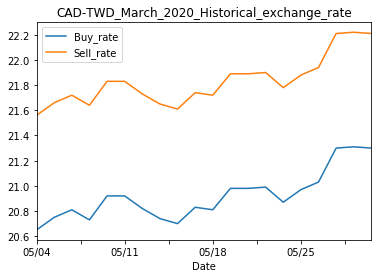

新加坡幣(SGD)


<Figure size 720x576 with 0 Axes>

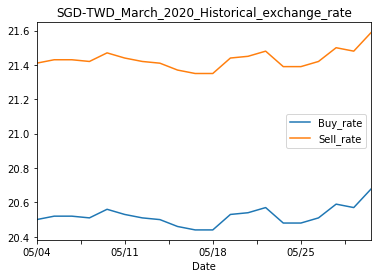

瑞士法郎(CHF)


<Figure size 720x576 with 0 Axes>

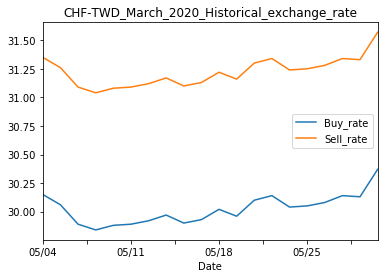

日圓(JPY)


<Figure size 720x576 with 0 Axes>

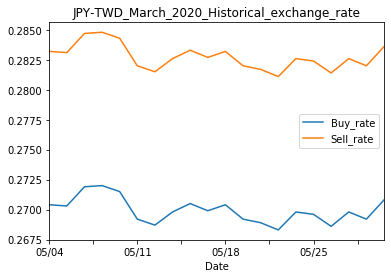

南非幣(ZAR)


<Figure size 720x576 with 0 Axes>

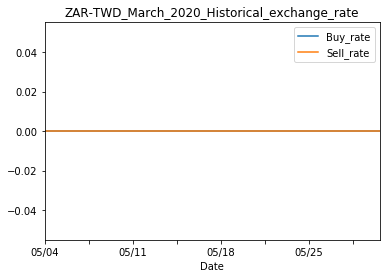

瑞典幣(SEK)


<Figure size 720x576 with 0 Axes>

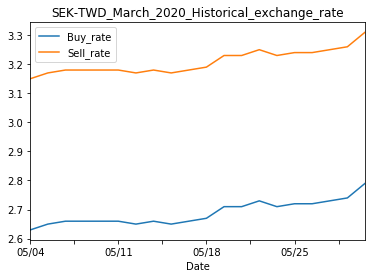

紐元(NZD)


<Figure size 720x576 with 0 Axes>

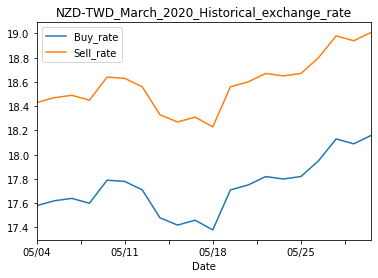

泰幣(THB)


<Figure size 720x576 with 0 Axes>

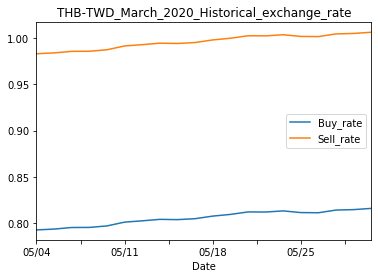

菲國比索(PHP)


<Figure size 720x576 with 0 Axes>

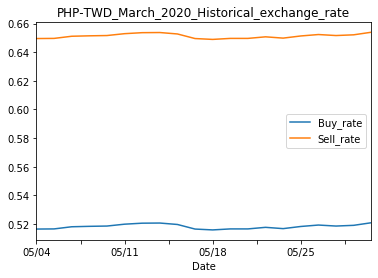

印尼幣(IDR)


<Figure size 720x576 with 0 Axes>

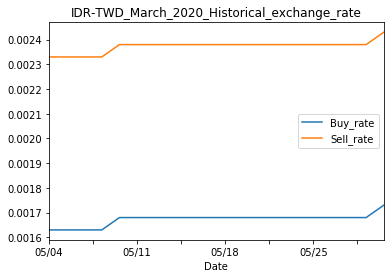

歐元(EUR)


<Figure size 720x576 with 0 Axes>

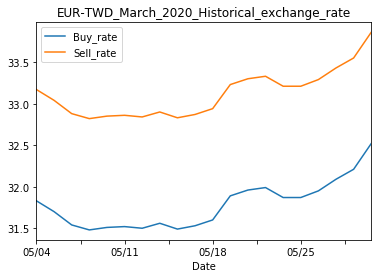

韓元(KRW)


<Figure size 720x576 with 0 Axes>

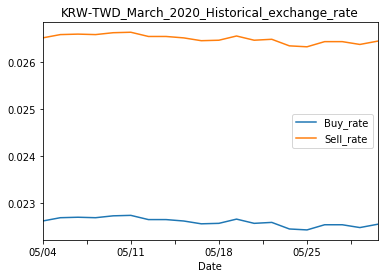

越南盾(VND)


<Figure size 720x576 with 0 Axes>

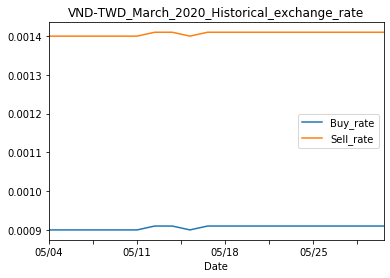

馬來幣(MYR)


<Figure size 720x576 with 0 Axes>

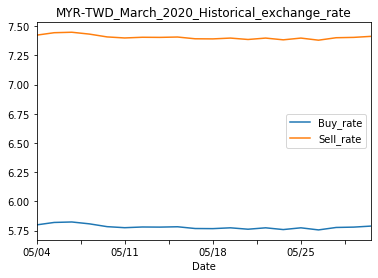

人民幣(CNY)


<Figure size 720x576 with 0 Axes>

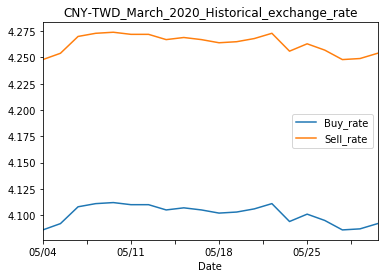

In [13]:

#USD的東西變成i，然後整個塞到for迴圈做就ok了


# 先到牌告匯率首頁，爬取所有貨幣的種類
all_currency
# 擷取匯率表格，把美金(也就是匯率表的第一個元素)擷取出來，查詢其歷史匯率
   #***
for i in all_currency:
        #***
    name=i.find('div').find('div',class_='hidden-phone print_show').text.replace(' ','').replace('\t','').replace('\n','').replace('\r','')
    print(name)  #套到i，那就是print不同的貨幣名稱
     #等下改名用
    
    currency_code=re.findall(('\w{3}'),str(name))[-1]   #這邊的\w{3}超傻眼，原來他還可以匹配到中文，一旦幣值名稱為3字以上，如加拿大幣他就會匹配到，所以取[-1]一定沒錯
    
# 針對美金，找到其「歷史匯率」的首頁 

    #*********************這邊開始就是在進行一個改網頁的動作*********************
    
    #***                       #***
    a='https://rate.bot.com.tw'+i.find(name='td', attrs={'data-table':'歷史匯率'}).a['href']
    #*********************a就會等於新的網址，然後在i裡面一直換成不同貨幣的網址*********************
    
# 到貨幣歷史匯率網頁，選擇該貨幣的「歷史區間」，送出查詢後，觀察其網址變化情形，再試著抓取其歷史匯率資料

# 用「quote/年-月」去取代網址內容，就可以連到該貨幣的歷史資料

#*********************這邊就是把他replace成「已篩選過為指定2020年5月」的網址，原本他中間叫history，而後面的/就是貨幣一直在變*********************
   #***
    i_history_March = a.replace('history','quote/2020-05')
    march_quote=BeautifulSoup(requests.get(i_history_March).text,'lxml')
    march_table=march_quote.find('table',title="歷史本行營業時間牌告匯率").find('tbody').find_all('tr')
# 擷取到歷史匯率資料後，把資料彙整起來並畫出趨勢圖
#開空LIST
    history_date = list()
    history_buy = list()
    history_sell = list()

#開始丟東西進去
    for d in march_table:
    
    #先把日期丟進去
        date_string = d.a.get_text()     #這日期好像不換也沒差?，但換了感覺是確保等下一定是正確的格式
        date = datetime.strptime(date_string, '%Y/%M/%d').strftime('%Y/%M/%d')  # 轉換日期格式
        history_date.append(date.replace('2020/',''))
    
                        #find_all是因為剛好買入賣出都是同名，然後等下用[0][1]篩選
        history_ex_rate=d.find_all('td',class_="rate-content-cash text-right print_table-cell")
    
    #本行買入丟進去            #float()因為他是str的型態，所以要換成float型態
        history_buy.append(float(history_ex_rate[0].text))   # 歷史買入匯率
    
    #本行賣出丟進去
        history_sell.append(float(history_ex_rate[1].text)) # 歷史賣出匯率

# 將匯率資料建成dataframe形式           #順便改名
    data=pd.DataFrame({'Date': history_date,
                   'Buy_rate':history_buy,
                   'Sell_rate':history_sell})

    data = data.set_index('Date')  # 指定日期欄位為datafram的index
    data = data.sort_index(ascending=True)

# 畫出歷史匯率軌跡圖
    plt.figure(figsize=(10,8))  #設定他的解析度?
    data[['Buy_rate','Sell_rate']].plot()  #這邊是否就是指定index的用意?
    plt.legend(loc='best') #這個是設定他的圖示在哪邊  用best就是最佳化，不擋圖? #upper left/right , lower left/right ,center  之類的
    plt.title('{}-TWD_March_2020_Historical_exchange_rate'.format(currency_code))  #命名
    plt.show() #呈現
